# Vocabulary Curation for Environmental Science NER

## 1. Introduction

### 1.1 Background and Purpose

This notebook focuses on building a vocabulary of environmental terms to support later stages of Named Entity Recognition (NER). It is the second step in a pipeline designed to develop a domain-specific NER dataset, following on from the raw text preparation carried out in `01_data_collection.ipynb`.

The aim is to identify and organise key domain-specific terms that appear in environmental texts. These include species names, habitat types, ecological processes, pollutants, and scientific measurements. General-purpose NER models often fail to capture such terms accurately, as they are either underrepresented or entirely absent in mainstream corpora.

The vocabulary lists created here will be used in the next step to apply rule-based annotation. This pre-annotation will enable the creation of weakly labelled data, where entity tags are assigned automatically based on term matches rather than manual annotation. This data will then be used to train statistical and machine learning models for environmental NER. As a result, this stage is critical in determining the coverage and relevance of named entities in the training set.

Vocabulary terms are gathered from a range of publicly available sources, including domain-specific glossaries, classification systems, and structured datasets. Some are extracted using scripts, while others are compiled manually. The final outputs will be cleaned, deduplicated, and stored in a structured format ready for annotation.

### 1.2 Objectives

The main objectives of this notebook are:

- To define a set of named entity categories that reflect the types of concepts commonly found in environmental science
- To identify and extract vocabulary terms for each category from trusted sources, including ontologies, glossaries, and environmental datasets
- To standardise and clean the collected terms, removing duplicates and formatting them consistently
- To save the resulting vocabulary files in a format suitable for rule-based matching and future model training

Each category is handled in a separate section, with a clear explanation of sources used, any filtering applied, and a final cleaned list. These outputs will be used to annotate the sentence-level dataset produced earlier in the pipeline.

### 1.3 Challenges in Vocabulary Development

Developing vocabulary lists for environmental NER presents several challenges that need to be addressed carefully:

- **Choosing meaningful categories**  
  There is no single standard for environmental entity types. Categories must be defined based on project needs, typical text content, and the structure of existing ontologies. Each category should be well defined and distinct from the others.

- **Finding reliable and relevant sources**  
  Domain-specific terms are spread across many different resources. These resources vary in structure and accessibility. Some are easy to extract from; others require manual effort or custom scripts. Some of these are easy to extract; others require manual effort or custom scripts.

- **Managing ambiguity**  
  Certain terms have multiple meanings in different contexts. For example, “lead” may refer to a pollutant or act as a verb. These terms need to be flagged and treated cautiously during annotation.

- **Balancing coverage with precision**  
  A broad vocabulary may capture more entities but also introduces noise. It is important to focus on terms that are likely to appear in the corpus and are useful for the task. Rare, overly general, or ambiguous entries may be excluded or reviewed manually.

- **Handling formatting inconsistencies**  
  Terms from different sources may vary in spelling, case, pluralisation, or punctuation. A standard cleaning process is needed to normalise these variations and ensure consistent matching later.

These challenges underline the need for a clear and reproducible method for vocabulary collection. Each step must be documented and carefully structured to ensure high-quality results in the next phase of the pipeline.


## 2. Defining Entity Categories

### 2.1 Choosing the Entity Categories

Named Entity Recognition in environmental science requires clearly defined entity types that reflect the domain’s specialised vocabulary. General NER categories, such as “Organisation” or “Location,” are not specific enough to capture the kinds of entities that appear in environmental text. Terms such as species names, habitat descriptors, or chemical pollutants need to be grouped meaningfully to support accurate tagging.

The categories chosen for this notebook aim to balance three key criteria: specificity, clarity, and practical relevance. Each category should represent a well-understood environmental concept, be distinct from the others, and be useful for annotating terms that frequently appear in environmental documents. This includes both scientific abstracts and semi-structured metadata.

The category design also draws on patterns seen in domain vocabularies, classification systems, and earlier review of the text corpus collected earlier. These sources reveal recurring term types such as biological taxa, ecosystem names, pollution indicators, and measurement units. Grouping these into separate categories improves both annotation consistency and future model training.

### 2.2 Category Review Process
The selection of entity categories was based on a review of environmental materials and the text data collected earlier. The aim was to identify recurring patterns in how key concepts are mentioned and described across different sources.

To guide this process, a range of domain-specific materials were considered, including glossaries, classification systems, and datasets. These were not used to define categories directly, but to observe common term types that appear in environmental science. In parallel, the collected corpus was manually reviewed to spot frequent entities and assess their natural groupings.

The process was iterative. Some categories, such as species names and pollutants, were clearly distinguishable from the start. Others, like environmental processes or measurements, required refinement to avoid overlapping meanings or inconsistent boundaries. Wherever possible, categories were defined to be specific, distinct, and useful for labelling terms that appear regularly in environmental text.

### 2.3 Final Entity Categories

Based on the review process above, five named entity categories were selected. Each category is designed to capture a specific type of domain-relevant term found in environmental science text.

| Entity Category | Description | Example Terms |
|------------------|-------------|----------------|
| TAXONOMY         | Names of species, genera, families, or other taxonomic units | *Salmo salar*, *Panthera leo* |
| HABITAT          | Names of ecosystems, land cover types, or habitat descriptors | estuary, peatland, saltmarsh |
| ENV_PROCESS      | Environmental or ecological processes, including both natural and human-driven events | erosion, eutrophication, acidification |
| POLLUTANT        | Chemical or physical substances known to cause pollution or environmental harm | mercury, nitrate, microplastics |
| MEASUREMENT      | Units, quantities, or indicators used to measure environmental variables | pH, mg/L, temperature, CO₂ levels |

These categories are used to group vocabulary terms in the next sections. Each term list is built and processed separately, then saved in a structured format for annotation.


## 3. Collecting Vocabulary Terms
This section focuses on building the vocabulary lists for each of the entity categories defined earlier. For each category, relevant terms are collected from domain-specific resources such as glossaries, classification systems, and downloadable datasets. Where possible, structured sources are processed programmatically. Others are manually reviewed or extracted depending on format and accessibility.

The goal is to compile targeted, category-specific lists that reflect the kinds of entities typically found in environmental science texts. Each vocabulary is cleaned, standardised, and saved in a structured format for later use in annotation and model development.

In [19]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random
import re
from pathlib import Path

BASE_PATH = Path("../vocabs")
RAW_PATH = BASE_PATH / "raw"
EXTRACTED_PATH = BASE_PATH / "extracted"
FINAL_PATH = BASE_PATH / "final"

RAW_PATH.mkdir(parents=True, exist_ok=True)
EXTRACTED_PATH.mkdir(parents=True, exist_ok=True)
FINAL_PATH.mkdir(parents=True, exist_ok=True)

### 3.1 Taxonomy

The taxonomy vocabulary is based on the GBIF Backbone Taxonomy dataset [link](https://www.gbif.org/dataset/d7dddbf4-2cf0-4f39-9b2a-bb099caae36c), which provides a large set of biological names across all major taxonomic groups. The raw file was downloaded as a TSV and includes a wide range of vernacular terms.

In [2]:
df = pd.read_csv(RAW_PATH / "VernacularName.tsv", sep='\t', dtype=str)
df.head()

,taxonID,vernacularName,language,country,countryCode,sex,lifeStage,source
0,5371864,sels næp,no,NaN,NaN,NaN,NaN,Nordic plant uses from Gunnerus and Høeg
1,5371864,spreng-rood,no,NaN,NaN,NaN,NaN,Nordic plant uses from Gunnerus and Høeg
2,5371864,syle-næbber,no,NaN,NaN,NaN,NaN,Nordic plant uses from Gunnerus and Høeg
3,3034225,angelsrot,NaN,NaN,NaN,NaN,NaN,Nordic plant uses from Gunnerus and Høeg
4,3034225,mjølkerot,NaN,NaN,NaN,NaN,NaN,Nordic plant uses from Gunnerus and Høeg


An initial preview of the file revealed that the entries span multiple languages, stored under a `language` column. Since the corpus being annotated is in English, only entries marked as English (`language == 'en'`) are retained for this stage.

In [78]:
df = pd.read_csv(RAW_PATH / "VernacularName.tsv", sep='\t', usecols=["vernacularName", "language"], dtype=str)

df = df[df["language"] == "en"]
df = df.dropna(subset=["vernacularName"])
df["vernacularName"] = df["vernacularName"].str.strip().str.lower()
df = df[df["vernacularName"] != ""]

taxonomy_terms = df["vernacularName"].drop_duplicates().sort_values()

taxonomy_path = EXTRACTED_PATH / "taxonomy.txt"
taxonomy_path.parent.mkdir(parents=True, exist_ok=True)
taxonomy_terms.to_csv(taxonomy_path, index=False, header=False)

In [79]:
print(len(taxonomy_terms))

229559


In [76]:
with open(output_path, "r", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline().strip())

abandoned industrial site
accidental release of organisms
afforestation
afforestations
agricultural landscape
alluvial plain
altitude
altitudes
amusement park
anaerobic lagoon


The extracted list contains approximately 229,000 unique English-language names. From a brief manual inspection, the terms appear accurate, well-formed, and highly relevant to biological taxonomy. Many include common species and group-level names, making this a strong starting point.

While the number of terms is large, it is not expected to negatively impact annotation. Any names not found in the corpus will simply not be matched. Basic cleaning will be applied later to remove duplicates, overly generic names, or problematic entries where necessary.

Due to the size of the list, full manual review is not feasible. However, spot checks indicate the data quality is high. A standardised version of the vocabulary will be prepared during the cleaning stage.

### 3.2 Habitat
The habitat vocabulary is based on the GEMET thesaurus, which includes a wide range of environmental and ecological terms. It provides structured terminology for describing natural environments, land cover types, and habitat-related concepts. The terms were downloaded in structured format and filtered for habitat-relevant entries.

In [57]:
def scrape_gemet_theme(theme_id: int):
    """Scrapes GEMET terms under a given theme and writes them to a text file"""
    
    base_url = f"https://www.eionet.europa.eu/gemet/en/theme/{theme_id}/concepts/?page={{}}&letter=0"
    
    page = 1
    terms = set()

    print(f"Scraping theme ID {theme_id}")
    
    while True:
        url = base_url.format(page)
        print(f"Page {page}")
        response = requests.get(url)
        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.content, "html.parser")
        term_elements = soup.select("ul.listing.columns.split-20 li a")
        if not term_elements:
            break

        new_terms = {el.get_text(strip=True) for el in term_elements}
        if new_terms.issubset(terms):
            break

        terms.update(new_terms)
        page += 1
        time.sleep(0.5)

    return sorted(terms)

In [59]:
habitat_terms = scrape_gemet_theme(theme_id=23)

output_path = EXTRACTED_PATH / "habitat.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for term in habitat_terms:
        f.write(term + "\n")

print(f"Saved habitat terms to {output_path.name}")

Scraping theme ID 23
Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Saved habitat terms to habitat.txt


In [62]:
print(len(habitat_terms))

467


In [64]:
with open(output_path, "r", encoding="utf-8") as f:
    terms = [line.strip() for line in f if line.strip()]

sampled = random.sample(terms, 20)
for term in sampled:
    print(term)

temperate woodland
wildlife sanctuary
dam draining
coast protection
rivers
periurban space
site rehabilitation
area under stress
resource scarcity
bays
forest fire
cultural ecosystem services
coastal environment
fens
nesting area
forest
forest reserve
integrated environmental assessment
bocages
abandoned industrial site


The extracted list for habitat terms includes 467 unique entries from the GEMET thesaurus under the "natural areas" theme. While this number is smaller compared to the taxonomy list, it is expected since habitats are a more constrained and well-defined concept, with fewer distinct variations than species names.

The list covers a broad set of environments, including terms such as *marshes*, *coastal environment*, *catchment area*, *bog*, *sand dune fixation*, *mountain forest*, and *terraced landscape*. These are well-formed, domain-relevant, and reflect both natural and managed habitats.

Initial inspection confirms the quality and relevance of the terms. The vocabulary will be further cleaned and standardised before annotation, but no immediate expansion is needed unless specific gaps are identified later.


### 3.3 Environmental Processes
This category includes vocabulary terms that describe natural, physical, or chemical processes occurring within the environment. These may include terms related to climate, hydrology, soil dynamics, pollution cycles, and other system-level interactions commonly found in environmental science texts.

The goal is to capture processes that are relevant to ecological modelling, environmental monitoring, and scientific descriptions of system change.

In [65]:
env_process_path = EXTRACTED_PATH / "env_process.txt"

climate_terms = scrape_gemet_theme(theme_id=7)

with open(env_process_path, "w", encoding="utf-8") as f:
    for term in climate_terms:
        f.write(term + "\n")

print(f"Saved env_process terms to {env_process_path.name}")

Scraping theme ID 7
Page 1
Page 2
Page 3
Page 4
Page 5
Saved env_process terms to env_process.txt


In [66]:
print(len(climate_terms))

128


In [67]:
with open(env_process_path, "r", encoding="utf-8") as f:
    terms = [line.strip() for line in f if line.strip()]

sampled = random.sample(terms, 20)
for term in sampled:
    print(term)

precipitation enhancement
season
meteorological disaster
oceanic climate
flood forecast
haze
atmospheric structure
climate regulation
tornado
weather modification
snow
storm damage
air conditioning
troposphere
meteorological research
mountain climate
ozone layer
atmospheric precipitation
climate protection
atmospheric composition


The environmental process vocabulary was initially sourced from the GEMET thesaurus under the "climate" theme, which produced 128 terms. This list includes core concepts such as *global warming*, *ozone layer*, *atmospheric composition*, *feedback loop*, and *water scarcity*.

While these are relevant and well-formed, the coverage is narrow and heavily climate-focused. Environmental processes span a wider range of concepts including soil dynamics, chemical pollution cycles, hydrology, and ecosystem-level change. These are not well represented in the current list.

Additional sources will be explored to expand this vocabulary, including manually compiled lists and process-focused glossaries or ontologies. The GEMET terms will still be included as part of the final vocabulary after cleaning and standardisation.


In [68]:
theme_ids = {
    "climate": 5,
    "pollution": 26,
    "natural_dynamics": 36,
}

all_terms = set()

for theme, theme_id in theme_ids.items():
    print(f"Scraping: {theme}")
    
    terms = scrape_gemet_theme(theme_id)
    all_terms.update(term.lower() for term in terms if term.strip())
    
    with open(env_process_path, "r", encoding="utf-8") as f:
        for line in f:
            term = line.strip().lower()
            if term:
                all_terms.add(term)

with open(env_process_path, "w", encoding="utf-8") as f:
    for term in sorted(all_terms):
        f.write(term + "\n")

Scraping: climate
Scraping theme ID 5
Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Scraping: pollution
Scraping theme ID 26
Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Page 14
Page 15
Page 16
Scraping: natural_dynamics
Scraping theme ID 36
Page 1
Page 2


In [69]:
print(len(all_terms))

1003


In [70]:
with open(env_process_path, "r", encoding="utf-8") as f:
    terms = [line.strip() for line in f if line.strip()]

sampled = random.sample(terms, 20)
for term in sampled:
    print(term)

microclimate
land restoration
combined cycle-power station
tundra
bleaching process
anaerobic treatment
advection
building service
chemical decontamination
environmental impact of agriculture
hail
salination
polluter-pays principle
olfactory pollution
nursery garden
water pollution
pollution monitoring
building site
physical alteration
sea level rise


The expanded list for environmental processes now includes 1,003 unique terms aggregated from multiple GEMET themes, including climate, pollution, and natural dynamics. This broader coverage captures a wide range of relevant concepts such as microclimate, chemical decontamination, salination, environmental impact of agriculture, and pollution monitoring. While some entries are loosely defined or overlap with other categories, the overall list is diverse and strongly aligned with the types of system-level processes found in environmental science literature. The vocabulary will be reviewed and refined in the next stage to remove ambiguous or overly general terms, but the current coverage is considered sufficient for initial annotation.

### 3.4 Pollutants
The pollutants vocabulary includes chemical substances and other environmental stressors that are commonly referenced in environmental science. These may be individual compounds such as benzene or lead, or broader classes such as pesticides, microplastics, or particulate matter. These terms are often found in regulatory reports, monitoring programmes, and scientific publications that focus on pollution, exposure, and environmental impact.

To build this vocabulary, the Toxics Release Inventory (TRI) Chemical List was selected as the source. This is a publicly available list of substances that are tracked under the US EPA’s TRI reporting programme, which requires facilities to report on the management of certain toxic chemicals. The list is maintained as part of the EPA’s environmental transparency efforts and includes both individual chemicals and chemical categories.

The full list was downloaded in spreadsheet format from the following source:
https://www.epa.gov/toxics-release-inventory-tri-program/tri-listed-chemicals

In [33]:
df = pd.read_excel(RAW_PATH / "2024_tri_chemical_list.xlsx", engine="openpyxl")
df.head()

/home/hkhan/Projects/env-ner-project/.venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,CASRN,TRI Chemical or Chemical Category Name,Chemical Structure,De Minimis Limit %,"M,P/OU Thresholds (lb)",Category Description,Category Member,Additional Information
0,71751-41-2,Abamectin,NaN,1,"25,000/10,000",NaN,NaN,NaN
1,30560-19-1,Acephate,NaN,1,"25,000/10,000",NaN,NaN,NaN
2,75-07-0,Acetaldehyde,NaN,0.1,"25,000/10,000",NaN,NaN,NaN
3,60-35-5,Acetamide,NaN,0.1,"25,000/10,000",NaN,NaN,NaN
4,75-05-8,Acetonitrile,NaN,1,"25,000/10,000",NaN,NaN,NaN


The TRI chemical file includes a structured list of pollutant names, along with metadata such as CAS numbers, thresholds, and classification notes. A preview of the dataset shows chemical entries like Abamectin, Acetaldehyde, and Acetonitrile, which reflect a balance of technical specificity and practical relevance.

This initial inspection confirms that the file contains suitable pollutant terms for vocabulary extraction. Further processing will focus on selecting and standardising these names into a plain text list for use in annotation.

In [34]:
df.columns = df.columns.str.strip()

pollutant_terms = (
    df["TRI Chemical or Chemical Category Name"]
    .dropna()
    .astype(str)
    .str.strip()
    .str.lower()
    .drop_duplicates()
    .sort_values()
)

pollutant_path = EXTRACTED_PATH / "pollutant.txt"
pollutant_path.parent.mkdir(parents=True, exist_ok=True)
pollutant_terms.to_csv(pollutant_path, index=False, header=False)

In [35]:
len(pollutant_terms)

728

In [36]:
with open(pollutant_path, "r", encoding="utf-8") as f:
    terms = [line.strip() for line in f if line.strip()]

sampled = random.sample(terms, 20)
for term in sampled:
    print(term)

dichlorobromomethane
nickel
paraldehyde
acrolein
bromine
dihydrosafrole
cycloate
"3,3'-dimethylbenzidine dihydrofluoride"
"3,3'-dimethylbenzidine dihydrochloride"
triforine
diaminotoluene (mixed isomers) (toluenediamine)
c.i. direct blue 218
"hexamethylene-1,6-diisocyanate"
"1,2-dichloro-1,1,3,3,3-pentafluoropropane (hcfc-225da)"
"1,2,3,7,8‑pentachlorodibenzo-p-dioxin"
chlorothalonil
2-nitrophenol (o-nitrophenol)
perchloromethyl mercaptan
sodium azide
"1,1,2,2-tetrachloroethane"


A total of 728 unique pollutant terms were extracted from the TRI list. The sample includes a mix of well-formed names and more complex entries, such as those wrapped in quotation marks or containing grouped chemicals.

Basic cleaning will be applied to remove entries with formatting issues or compound categories that are too broad for direct annotation. Since the list is relatively small, this will be done manually.

Some common terms like pesticide, ozone, or microplastic are not included in the TRI list. These will be added separately to improve coverage across general environmental texts.

### 3.5 Measurements
This category covers vocabulary related to physical units, environmental quantities, and measurement-related descriptors. These often appear alongside named entities or as standalone spans in scientific texts, particularly when reporting thresholds, concentrations, or observed values.

Examples include standard expressions such as mg/L, µg/m3, °C, ppm, as well as context-specific terms like emission factor, exceedance, and threshold concentration. Recognising these phrases is important for accurate annotation and for interpreting the significance of quantitative information in environmental contexts.

The collected dataset contains a wide variety of these patterns in both structured and unstructured form. Terms like 25°C, 2 mg/L, and sound level (decibels) appear frequently, with and without spacing. These variations will be captured in the vocabulary to improve annotation quality and allow models to generalise across expression formats.

To support this, one of the sources used is a structured reference list of units based on the Unified Code for Units of Measure (UCUM): https://ucum.org/docs . UCUM provides a machine-readable and standardised set of units that includes SI, derived, and domain-relevant formats. These are well suited to controlled vocabulary development, where consistency and interoperability are important.

In [8]:
ucum_path = Path("../vocabs/raw/TableOfUcumCodes.xlsx")

df = pd.read_excel(ucum_path, engine="openpyxl", skiprows=1)
df.head()

,Row # (not a code),UCUM_CODE,Description of the Unit \n(using UCUM descriptions where they exist),Comment,Last Updated (see Revisions tab for details),Version correction published,Corrected by (initials RG = Rebecca Goodwin),Row # \nat time of correction (not a code),Previous UCUM version (with Errors or Omissions),Description of Change Made
0,1,10.L/min,10 liter per minute,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,2,10.L/(min.m2),10 liter per minute per square meter,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,3,10.uN.s/(cm5.m2),10 micronewton second per centimeter to the fi...,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,4,10*4/uL,10 thousand per microliter,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,5,10*8,100 million,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [12]:
df = df.dropna(subset=["UCUM_CODE"])

units = set()
for raw_unit in df["UCUM_CODE"]:
    # Remove everything inside parentheses
    cleaned = re.sub(r"\(.*?\)", "", raw_unit)

    # Remove leading numeric prefixes (e.g. 10., 10*4/)
    cleaned = re.sub(r"^[\d\.\*/]+", "", cleaned)

    # Remove whitespace and keep only alphanumeric + slash + dot
    cleaned = re.sub(r"[^\w/\.]", "", cleaned)

    if cleaned:
        units.add(cleaned.lower())

units = sorted(units)
output_path = EXTRACTED_PATH / "measurement.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for unit in units:
        f.write(unit + "\n")

In [13]:
len(units)

733

In [17]:
sampled = random.sample(units, 20)
for term in sampled:
    print(term)

l/min
umol/molhb
cm2
oif
nkat
ug/kg/min
log_iu/ml
h/d
ug/l/
ahfu
gtot_nit
uu/g
mmol
lpf
bacteria
mmol/dl
g/h/m2
u/ghb
u/1010
meq/kg/h


A total of 733 unique measurement terms were extracted from the UCUM-based unit list. These include scientific and domain-specific expressions such as mg/min, g/kg/h, mmol, u/ghb, and log_iu/ml. The list also features more specialised indicators like immunecomplexu, hemolysis, and time- or dose-related forms such as at_60_min and ug/kg/min.

While the vocabulary provides strong technical coverage, it does not include simpler measurement descriptors commonly used in environmental texts. Terms like temperature, concentration, volume, wind speed, and AQI are absent from the list. To address this, a small number of additional terms will be manually added to improve coverage across both scientific and narrative styles of environmental writing.

Spot checks using the final list against a subset of the corpus showed high match rates for commonly used units and descriptors, supporting its suitability for annotation.

## 4. Cleaning and Standardising Vocabulary Terms
The vocabulary terms collected in the previous section come from a range of sources and file types. As a result, they include inconsistencies in case, punctuation, spacing, and structure. Some terms are duplicated or contain noise such as trailing symbols or placeholders.

To prepare them for matching and annotation, a shared cleaning pipeline is applied. This involves:

- Converting to lowercase and trimming whitespace
- Removing trailing punctuation and artefacts
- Filtering known junk or irrelevant terms
- Deduplicating
- Adding plural variants using `inflect`


In [63]:
vocab_dict = {}

for filepath in EXTRACTED_PATH.glob("*.txt"):
    category = filepath.stem
    with open(filepath, encoding="utf-8") as f:
        terms = [line.strip() for line in f if line.strip()]
    vocab_dict[category] = terms

for category, terms in vocab_dict.items():
    print(f"\n{category.upper()} – {len(terms)} terms")
    print("Sample:", terms[:5])


POLLUTANT – 808 terms
Sample: ['abamectin', 'acephate', 'acetaldehyde', 'acetamide', 'acetone']

ENV_PROCESS – 966 terms
Sample: ['abandoned industrial site', 'acceptable daily intake', 'acceptable risk level', 'access road', 'accidental release of organisms']

MEASUREMENT – 844 terms
Sample: ['/a', '/d', '/g', '/hpf', '/l']

HABITAT – 401 terms
Sample: ['abandoned industrial site', 'accidental release of organisms', 'agricultural landscape', 'alluvial plain', 'altitude']

TAXONOMY – 72970 terms
Sample: ['aaom snail', 'aardvark', 'aardvarks', 'aardwolf', 'aardwolves']


In [65]:
for category, terms in vocab_dict.items():
    print(f"{category.upper()} – {len(terms)}")

POLLUTANT – 808
ENV_PROCESS – 966
MEASUREMENT – 844
HABITAT – 401
TAXONOMY – 72970


### 4.1 Basic Cleaning
Manual inspection of the raw vocabulary lists showed a number of common issues, including inconsistent casing, stray punctuation, and trailing whitespace. These inconsistencies can affect exact matching during annotation.

To address this, basic cleaning is performed to standardises the format by lowercasing terms, removing artefacts, normalising spacing, and filtering out empty entries.

In [66]:
def clean_terms(raw_terms):
    """
    Basic cleaning for a list of terms:
    - Lowercase
    - Strip whitespace
    - Remove trailing punctuation
    - Collapse multiple spaces
    - Filter empty strings
    - Remove duplicates
    """
    cleaned = []
    for term in raw_terms:
        term = term.lower().strip()
        term = re.sub(r'[\.\,\;\:\'\"\)\(]+$', '', term)
        term = re.sub(r'\s+', ' ', term)
        
        if not term:
            continue
        cleaned.append(term)
    
    return list(dict.fromkeys(cleaned))

In [67]:
for category in vocab_dict:
    vocab_dict[category] = clean_terms(vocab_dict[category])

In [68]:
for category, terms in vocab_dict.items():
    print(f"{category.upper()} – {len(terms)}")

POLLUTANT – 805
ENV_PROCESS – 966
MEASUREMENT – 844
HABITAT – 401
TAXONOMY – 72968


### 4.2 Short Term Detection and Removal
Very short terms (fewer than 4 characters) are unlikely to be meaningful in most categories. These often include symbols, abbreviations, malformed fragments, or noise introduced during parsing. However, some short terms may be valid in specific contexts, such as chemical units or element symbols in the pollutant or measurement categories.

To identify potential junk entries, all terms under 4 characters are printed by category for manual inspection.


In [69]:
for category, terms in vocab_dict.items():
    short_terms = [t for t in terms if len(t) < 4]
    if short_terms:
        print(f"\n{category.upper()} – {len(short_terms)}")
        print(short_terms)


POLLUTANT – 13
['ash', 'cd', 'cds', 'cfc', 'ddt', 'hcl', 'ink', 'nox', 'pah', 'pb', 'pbs', 'pcb', 'tar']

ENV_PROCESS – 2
['fog', 'ice']

MEASUREMENT – 146
['/a', '/d', '/g', '/l', '/ml', '/ul', '/wk', 'a', 'a/m', 'aru', 'atm', 'au', 'bar', 'bq', 'cal', 'cel', 'cfu', 'cg', 'ch', 'cl', 'cm', 'cm2', 'cm3', 'cp', 'cpm', 'cst', 'd', 'd/', 'db', 'deg', 'dg', 'dl', 'dm', 'drp', 'eq', 'erg', 'ev', 'f', 'fg', 'fiu', 'fl', 'fm', 'g', 'g.m', 'g/', 'g/d', 'g/g', 'g/h', 'g/l', 'ghb', 'gy', 'h', 'h/d', 'hb', 'hpf', 'hz', 'inr', 'isr', 'iu', 'iu/', 'j', 'j/l', 'k', 'k/w', 'kat', 'kau', 'kg', 'kg/', 'kl', 'km', 'kpa', 'ks', 'ku', 'l', 'l/', 'l/d', 'l/h', 'l/l', 'l/s', 'lm', 'log', 'lpf', 'm', 'm/s', 'm2', 'm3', 'ma', 'meq', 'mg', 'mg/', 'min', 'ml', 'ml/', 'mm', 'mm2', 'mo', 'mol', 'mpa', 'ms', 'mv', 'n', 'n.s', 'ng', 'ng/', 'nl', 'nm', 'ns', 'ohm', 'oif', 'osm', 'pa', 'pg', 'ph', 'pl', 'pm', 'ppb', 'ppm', 'ps', 'psi', 'pt', 's', 'sv', 't', 'tbu', 'u', 'u/', 'u/d', 'u/g', 'u/h', 'u/l', 'u/s', 'ueq',

Some of the short terms in the taxonomy vocabulary were found to be invalid fragments, such as "x", "xes", or "le". These were not recognisable as valid species names or taxonomic entities.

The following entries are removed from the taxonomy list manually. Other categories are left unchanged for now, as many of their short terms are meaningful (e.g. "oz", "mg", "co").

In [70]:
junk_terms = {"x", "xes", "uku", "atu", "le", "de", "’s", "la", "el", "fo", "b", "z", "ye", "ha"}

vocab_dict["taxonomy"] = [t for t in vocab_dict["taxonomy"] if t not in junk_terms]

### 4.3 Checking for Duplicates Across Categories

Some terms may appear in more than one category. This can cause problems during annotation, where the same term could be labelled as multiple entity types.

To check for this, each pair of vocabulary categories is compared and any shared terms are printed. This helps identify overlaps that might need to be removed or reassigned.

In [71]:
from itertools import combinations

for (cat1, terms1), (cat2, terms2) in combinations(vocab_dict.items(), 2):
    overlap = set(terms1) & set(terms2)
    if overlap:
        print(f"\nOverlap between '{cat1}' and '{cat2}' ({len(overlap)} terms):")
        print(sorted(overlap))


Overlap between 'pollutant' and 'env_process' (10 terms):
['acid rain', 'algal bloom', 'asbestos', 'dust', 'industrial waste', 'nitrate', 'oil spill', 'radioactive waste', 'sewage', 'soot']

Overlap between 'env_process' and 'measurement' (3 terms):
['emission factor', 'soil salinity', 'turbidity']

Overlap between 'env_process' and 'habitat' (18 terms):
['abandoned industrial site', 'accidental release of organisms', 'amusement park', 'artificial lake', 'boreal forest dieback', 'botanical garden', 'camping site', 'ecotoxicological evaluation', 'estuary pollution', 'excavation site', 'field damage', 'glacier', 'holiday camp', 'industrial wasteland', 'polar region', 'polluted site', 'rain forest', 'urban green']

Overlap between 'habitat' and 'taxonomy' (2 terms):
['swamp', 'swamps']


Some terms appear in more than one category. To avoid ambiguity, each term is assigned to the category where it makes the most sense.

- Terms like "asbestos", "nitrate", and "soot" are pollutants, not processes.
- Physical places like "glacier", "camping site", or "urban green" belong in habitat, not env_process.
- Measurement-related terms such as "turbidity" and "emission factor" are kept in measurement only.
- "Swamp" and "swamps" are removed from taxonomy, since they describe habitats.

These terms are removed from the categories where they don’t belong.

In [72]:
remove_from_env_process = {
    "acid rain", "algal bloom", "asbestos", "dust", "industrial waste",
    "nitrate", "oil spill", "radioactive waste", "sewage", "soot",
    "emission factor", "soil salinity", "turbidity",
    "abandoned industrial site", "accidental release of organisms", "amusement park",
    "artificial lake", "boreal forest dieback", "botanical garden", "camping site",
    "ecotoxicological evaluation", "estuary pollution", "excavation site", "field damage",
    "glacier", "holiday camp", "industrial wasteland", "polar region", "polluted site",
    "rain forest", "urban green"
}

remove_from_taxonomy = {
    "swamp", "swamps"
}

vocab_dict["env_process"] = [
    t for t in vocab_dict["env_process"] if t not in remove_from_env_process
]

vocab_dict["taxonomy"] = [
    t for t in vocab_dict["taxonomy"] if t not in remove_from_taxonomy
]

In [73]:
for (cat1, terms1), (cat2, terms2) in combinations(vocab_dict.items(), 2):
    overlap = set(terms1) & set(terms2)
    if overlap:
        print(f"\nOverlap between '{cat1}' and '{cat2}' ({len(overlap)} terms):")
        print(sorted(overlap))

In [74]:
for category, terms in vocab_dict.items():
    print(f"{category}: {len(terms)} terms")

pollutant: 805 terms
env_process: 935 terms
measurement: 844 terms
habitat: 401 terms
taxonomy: 72963 terms


### 4.4 Pluralisation
Most vocabulary terms are stored in their singular form. However, the text corpus may contain both singular and plural mentions of the same entity, especially for common nouns like "lake" / "lakes" or "pesticide" / "pesticides".

If only the singular form is matched during annotation, many valid entity mentions could be missed. To avoid this, plural variants are added to each category using the `inflect` library. This improves recall during weak labelling by covering more surface forms without relying on exact duplicates.

In [75]:
import inflect

p = inflect.engine()

for category, terms in vocab_dict.items():
    expanded = set(terms)
    for term in terms:
        plural = p.plural(term)
        if plural != term:
            expanded.add(plural)
    vocab_dict[category] = sorted(expanded)

print("Plural variants added to all categories")

Plural variants added to all categories


In [76]:
for category, terms in vocab_dict.items():
    print(f"{category}: {len(terms)} terms")

pollutant: 1401 terms
env_process: 1868 terms
measurement: 1639 terms
habitat: 638 terms
taxonomy: 129474 terms


In [77]:
for category, terms in vocab_dict.items():
    print(f"\n{category.upper()}")
    count = 0
    for term in terms:
        plural = p.plural(term)
        if plural != term and plural in terms:
            print(f"  {term} → {plural}")
            count += 1
        if count == 5:
            break


POLLUTANT
  abamectin → abamectins
  abamectins → abamectin
  acephate → acephates
  acephates → acephate
  acetaldehyde → acetaldehydes

ENV_PROCESS
  acceptable daily intake → acceptable daily intakes
  acceptable risk level → acceptable risk levels
  access road → access roads
  acid deposition → acid depositions
  activated sludge → activated sludges

MEASUREMENT
  /a → /as
  /as → /a
  /d → /ds
  /ds → /d
  /g → /gs

HABITAT
  abandoned industrial site → abandoned industrial sites
  accidental release of organisms → accidental releases of organisms
  agricultural landscape → agricultural landscapes
  alluvial plain → alluvial plains
  altitude → altitudes

TAXONOMY
  aaom snail → aaom snails
  aardvark → aardvarks
  aardvarks → aardvark
  aardwolf → aardwolves
  aardwolve → aardwolves


The increase in term counts confirms that plural variants were successfully added. For example, `pollutant` grew from 805 to 1401 terms, and `taxonomy` nearly doubled in size.

This step ensures that plural mentions in the corpus are not missed during annotation. For example, "abamectin" → "abamectins" was correctly added in the `pollutant` category. These plural forms help capture more entity mentions without requiring duplicates in the original vocabulary.

In [79]:
for category, terms in vocab_dict.items():
    out_path = FINAL_PATH / f"{category}.txt"
    with open(out_path, "w", encoding="utf-8") as f:
        for term in terms:
            f.write(term + "\n")

## 5. Final Summary

### 5.1 Summary of Vocabulary Collection
Vocabulary terms were collected from a range of environmental sources, including glossaries, datasets, and controlled vocabularies. Terms were grouped into five entity categories: `taxonomy`, `habitat`, `env_process`, `pollutant`, and `measurement`.

Each list was cleaned and standardised to ensure consistency. This included removing duplicates, lowercasing, trimming whitespace, and handling invalid or ambiguous entries. Plural variants were also added to improve matching during annotation. Overlapping terms between categories were resolved manually to keep each entity type distinct.

The number of vocabulary terms varied significantly between categories. The `taxonomy` list contained over 72,000 terms due to access to large-scale organism name datasets. In contrast, the other categories ranged between 400 and 1,000 terms. This reflects the relative availability and maturity of structured terminologies in each subdomain. The chart below summarises this disparity.

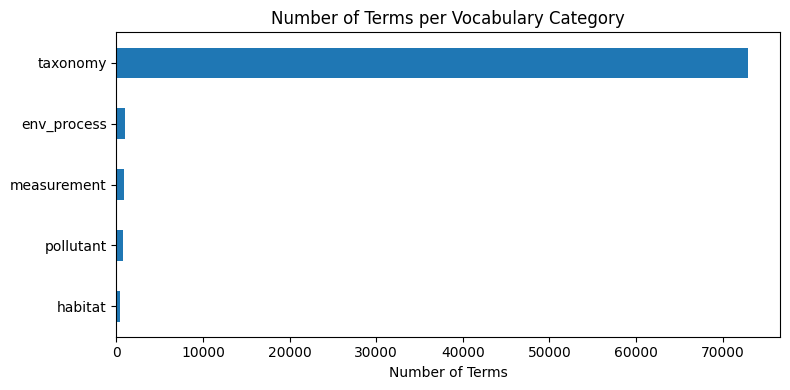

In [4]:
term_counts = {k: len(v) for k, v in vocab_dict.items()}

pd.Series(term_counts).sort_values().plot.barh(figsize=(8, 4), title="Number of Terms per Vocabulary Category")
plt.xlabel("Number of Terms")
plt.tight_layout()
plt.show()

The chart above shows a clear imbalance in term counts across the five entity categories. The `taxonomy` vocabulary is the largest, which reflects the scale and detail available in species databases. Other categories, such as pollutant, measurement, and env_process, have fewer terms due to the narrower scope of existing glossaries and ontologies.

Even with smaller counts, these vocabularies were built from high-quality sources and cover the key terms expected in environmental texts. They are suitable for weak labelling, particularly when combined with manual review and future refinement.

### 5.2 Next Steps
The cleaned vocabularies will be saved and used to weakly label the environmental text dataset in the next notebook. Terms will be matched against pre-segmented sentences using string-matching techniques such as Aho-Corasick.

After annotation, the dataset will be reviewed manually in Doccano. If relevant entity mentions are found that were not covered by the initial vocabularies, those terms will be added by hand. This final review helps fill in any gaps and ensures the vocabularies reflect real-world usage in the corpus.